In [1]:
# This notebook is used to analysis the noisy tubes by using MuonCalibration Ntuple for run456729
# latest data in folder cbnt_run456729_rawdata (15/03/2024)

# import the standard python module
import uproot
import pandas as pd
import sys,os, time, glob, re
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3
import splitter_regions_Run2
import mdtCalib_functions

In [10]:
# Load calibration ntuple for region 0120
dataFolder = 'cbnt_run456729_rawdata/'
listFile = os.listdir(dataFolder)
listFile.sort()
inputCalibNtuple="cbnt_run456729_rawdata/456729_fragments_reg0120_calibntuple24_dcsoff_0014_ntuple.root"
f = uproot.open(inputCalibNtuple)
treeName = "Segments"
tree = f[treeName]
df_all = tree.arrays()

In [40]:
# all branches name
print(tree.keys())
rawMdtBranches = ['rawMdt_id','rawMdt_adc','rawMdt_tdc']
trkHitBranches = ['trkHit_FixedId','trkHit_adc','trkHit_tdc','trkHit_driftTime','trkHit_resi','trkHit_driftRadius']

['event_bcId', 'event_eventNumber', 'event_lumiBlock', 'event_pt', 'event_runNumber', 'event_timeStamp', 'rawMdt_adc', 'rawMdt_gPosX', 'rawMdt_gPosY', 'rawMdt_gPosZ', 'rawMdt_id', 'rawMdt_nRMdt', 'rawMdt_tdc', 'trkHit_FixedId', 'trkHit_adc', 'trkHit_bkgTime', 'trkHit_calibStatus', 'trkHit_centerX', 'trkHit_centerY', 'trkHit_centerZ', 'trkHit_closestApproachX', 'trkHit_closestApproachY', 'trkHit_closestApproachZ', 'trkHit_distRO', 'trkHit_driftRadius', 'trkHit_driftTime', 'trkHit_gClosestApproachX', 'trkHit_gClosestApproachY', 'trkHit_gClosestApproachZ', 'trkHit_gPosX', 'trkHit_gPosY', 'trkHit_gPosZ', 'trkHit_localAngle', 'trkHit_lorTime', 'trkHit_nHits', 'trkHit_posX', 'trkHit_posY', 'trkHit_posZ', 'trkHit_propTime', 'trkHit_pull', 'trkHit_rTrk', 'trkHit_resi', 'trkHit_sagTime', 'trkHit_slewTime', 'trkHit_tdc', 'trkHit_tempTime', 'trkHit_tof', 'trkHit_trackIndex', 'trkHit_triggerTime', 'trkHit_tubeMeanAdc', 'trkHit_tubeT0', 'trkHit_type', 'trk_author', 'trk_chi2', 'trk_d0', 'trk_eta', 

In [44]:
# Get the dataframe df_all for chamber BIS7A16
# create two pandas dataframe for mdtRaw and trkHit
print(f'{inputCalibNtuple} contains {df_raw.shape[0]} raw hits and {df_trk.shape[0]} track hits')
#df_raw.rawMdt_station.value_counts()

/Users/zyan/opt/anaconda3/lib/python3.9/site-packages/uproot/interpretation/library.py:747: FutureWarning: MultiIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if hasattr(index, "is_integer") and index.is_integer():


cbnt_run456729_rawdata/456729_fragments_reg0120_calibntuple24_dcsoff_0014_ntuple.root contains 3471517 raw hits and 160554 track hits


In [22]:
%%time
df_raw= tree.arrays(rawMdtBranches,library = 'pd')
# # expand all raw hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])


CPU times: user 5min 23s, sys: 216 ms, total: 5min 23s
Wall time: 5min 28s


In [45]:
%%time

df_trk= tree.arrays(trkHitBranches,library = 'pd')
# # expand all track hits with correct chamberName and tubeInfo
df_trk['trkHit_tubeInfo'] = df_trk['trkHit_FixedId'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_trk['trkHit_station'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:7])
df_trk['trkHit_type'] = df_trk['trkHit_tubeInfo'].apply(lambda x :x[:3])

CPU times: user 15.2 s, sys: 14.6 ms, total: 15.3 s
Wall time: 15.3 s


In [24]:
# Save out BIS7A16 data
df_raw.head()
df_raw_BIS7A16 = df_raw[df_raw['rawMdt_station']=='BIS7A16']
df_raw_BIS7A16.head()

rawMdt_id  rawMdt_adc  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                      
0     5          24706992          39         586  BIS7A16-2-4-49   
      6          24706729         139         176  BIS7A16-2-2-42   
      7          24706480         152         464  BIS7A16-1-4-49   
      8          24706354         231         310  BIS7A16-1-3-51   
1     0          24706484          36         207  BIS7A16-1-4-53   

               rawMdt_station rawMdt_type  
entry subentry                             
0     5               BIS7A16         BIS  
      6               BIS7A16         BIS  
      7               BIS7A16         BIS  
      8               BIS7A16         BIS  
1     0               BIS7A16         BIS

In [26]:
df_raw_BIS7A16.shape

(268134, 6)

In [28]:
# count #Hit by rawMdt_tubeInfo
df_raw_BIS7A16['rawMdt_tubeInfo'].value_counts()

rawMdt_tubeInfo
BIS7A16-2-4-49    17064
BIS7A16-2-4-16    10000
BIS7A16-2-4-84     8455
BIS7A16-2-4-15     8192
BIS7A16-2-4-83     7207
                  ...  
BIS7A16-2-1-87       53
BIS7A16-2-1-12       10
BIS7A16-2-4-1        10
BIS7A16-2-4-2         1
BIS7A16-2-1-11        1
Name: count, Length: 647, dtype: int64

In [124]:
# cut ADC as 50
df_raw_BIS7A16_adcCut= df_raw_BIS7A16[df_raw_BIS7A16['rawMdt_adc'] >= 50]

# Group by 'rawMdt_tubeInfo' and calculate the sum of 'rawMdt_adc'
#grouped_data = df_raw_BIS7A16_adcCut.groupby('rawMdt_tubeInfo')['rawMdt_adc'].mean().reset_index()
# Group by 'rawMdt_tubeInfo', calculate the mean of 'rawMdt_adc', and count the number of hits
grouped_data = df_raw_BIS7A16_adcCut.groupby('rawMdt_tubeInfo').agg(
    meanADC=('rawMdt_adc', 'mean'),
    nHit=('rawMdt_adc', 'count')
).reset_index()

# Rename the 'rawMdt_adc' column to 'meanADC'
grouped_data.rename(columns={'rawMdt_adc': 'meanADC'}, inplace=True)
#grouped_data = grouped_data.sort_values(by='rawMdt_adc', ascending=False)

# Group by 'rawMdt_tubeInfo' and calculate the average of 'rawMdt_adc'
#grouped_data['meanADC'] = df_raw_BIS7A16_adcCut.groupby('rawMdt_tubeInfo')['rawMdt_adc'].transform('mean')

# Sort the grouped_data DataFrame by the 'meanADC' column in descending order
grouped_data = grouped_data.sort_values(by='meanADC', ascending=False)

# Print the sorted data
#print(sorted_data)
# Print the grouped data
noisyList = grouped_data[grouped_data['meanADC']< 115].rawMdt_tubeInfo.tolist()
noisyTube = grouped_data[grouped_data['meanADC']< 115]
print(noisyTube,noisyList)


    rawMdt_tubeInfo     meanADC  nHit
345  BIS7A16-2-1-84  110.744898    98
632  BIS7A16-2-4-84  106.392882  7221
599  BIS7A16-2-4-54  106.277389   429
267  BIS7A16-2-1-12  101.000000     1
266  BIS7A16-2-1-11   94.000000     1
54   BIS7A16-1-1-59   92.769492   295
605   BIS7A16-2-4-6   92.531863   408
633  BIS7A16-2-4-85   91.630435   138
635  BIS7A16-2-4-87   90.729258   229
313  BIS7A16-2-1-55   84.038462   312
557  BIS7A16-2-4-15   82.265162   709
346  BIS7A16-2-1-85   79.351792   614
505  BIS7A16-2-3-55   79.253283   533
634  BIS7A16-2-4-86   75.954397   307
631  BIS7A16-2-4-83   73.198686  2436
538  BIS7A16-2-3-85   68.813665  1288
593  BIS7A16-2-4-49   65.960523  3977
558  BIS7A16-2-4-16   59.473316  2286
551   BIS7A16-2-4-1   58.000000     2 ['BIS7A16-2-1-84', 'BIS7A16-2-4-84', 'BIS7A16-2-4-54', 'BIS7A16-2-1-12', 'BIS7A16-2-1-11', 'BIS7A16-1-1-59', 'BIS7A16-2-4-6', 'BIS7A16-2-4-85', 'BIS7A16-2-4-87', 'BIS7A16-2-1-55', 'BIS7A16-2-4-15', 'BIS7A16-2-1-85', 'BIS7A16-2-3-55', 'BIS7A

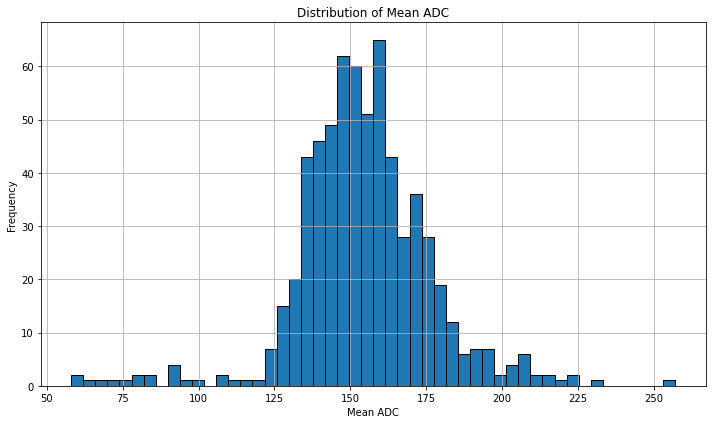

In [79]:
# meanADC 1D histogram
import matplotlib.pyplot as plt

# Assuming grouped_data is your DataFrame containing the meanADC column
# Plot meanADC column as a 1D histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(grouped_data['meanADC'], bins=50, edgecolor='black')  # Create a histogram with 20 bins
plt.xlabel('Mean ADC')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('Distribution of Mean ADC')  # Set the title
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot


# # Plot meanADC column
# plt.figure(figsize=(10, 6))  # Set the figure size
# plt.bar(grouped_data['rawMdt_tubeInfo'], grouped_data['meanADC'])  # Create a bar plot
# plt.xlabel('rawMdt_tubeInfo')  # Set the x-axis label
# plt.ylabel('Mean ADC')  # Set the y-axis label
# plt.title('Mean ADC by rawMdt_tubeInfo')  # Set the title
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show()  # Display the plot

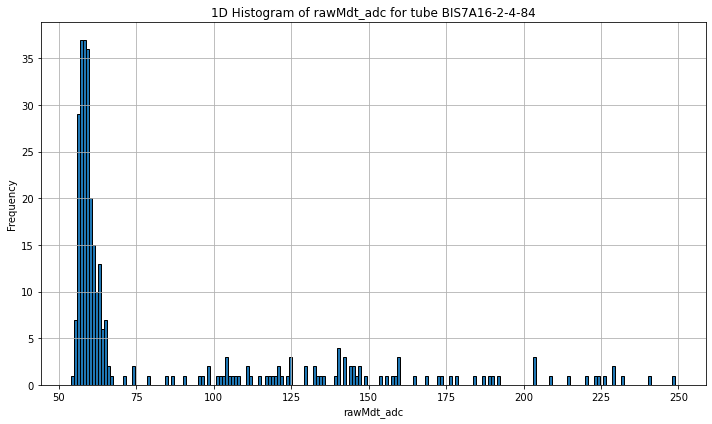

In [111]:
# Filter the DataFrame to retain rows where 'rawMdt_tubeInfo' is 'BIS7A16-2-4-84'
filtered_df = df_raw_BIS7A16_adcCut[df_raw_BIS7A16_adcCut['rawMdt_tubeInfo'] == 'BIS7A16-2-1-55']

# Plot a 1D histogram of 'rawMdt_adc' values for the filtered tube
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(filtered_df['rawMdt_adc'], bins=200, edgecolor='black')  # Create a histogram with 20 bins
plt.xlabel('rawMdt_adc')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('1D Histogram of rawMdt_adc for tube BIS7A16-2-4-84')  # Set the title
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

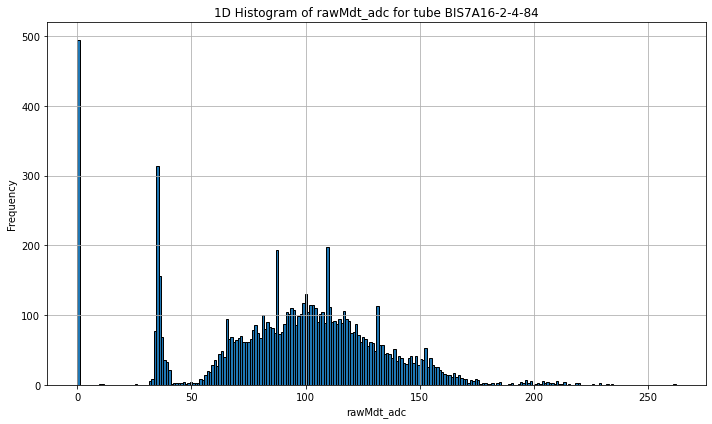

In [121]:
# Filter the DataFrame to retain rows where 'rawMdt_tubeInfo' is 'BIS7A16-2-4-84'
filtered_df = df_raw_BIS7A16[df_raw_BIS7A16['rawMdt_tubeInfo'] == 'BIS7A16-2-4-84']

# Plot a 1D histogram of 'rawMdt_adc' values for the filtered tube
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(filtered_df['rawMdt_adc'], bins=250, edgecolor='black')  # Create a histogram with 20 bins
plt.xlabel('rawMdt_adc')  # Set the x-axis label
plt.ylabel('Frequency')  # Set the y-axis label
plt.title('1D Histogram of rawMdt_adc for tube BIS7A16-2-4-84')  # Set the title
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

In [ ]:
# Plot 2D histogram noiseRate vs TubeId by using df_all 
 

In [ ]:
# Get the nosiy tube list by using cut 20k


In [1]:
# Plot the ADC and TDC for the most noisy tube MLx-x-xx


In [ ]:
# Get the dataframe df_adcCut by apply ADC cut > 50
df_adcCut = df_raw_BIS7A16


In [ ]:
# Plot 1D histogarm AverageADC and 2D histogram AverageADC vs TubeId by using df_adcCut


In [ ]:
# Get the tube list by using cut AverageADC < 100


In [ ]:
# Plot the ADC and TGC for the lowest AverageADC tube


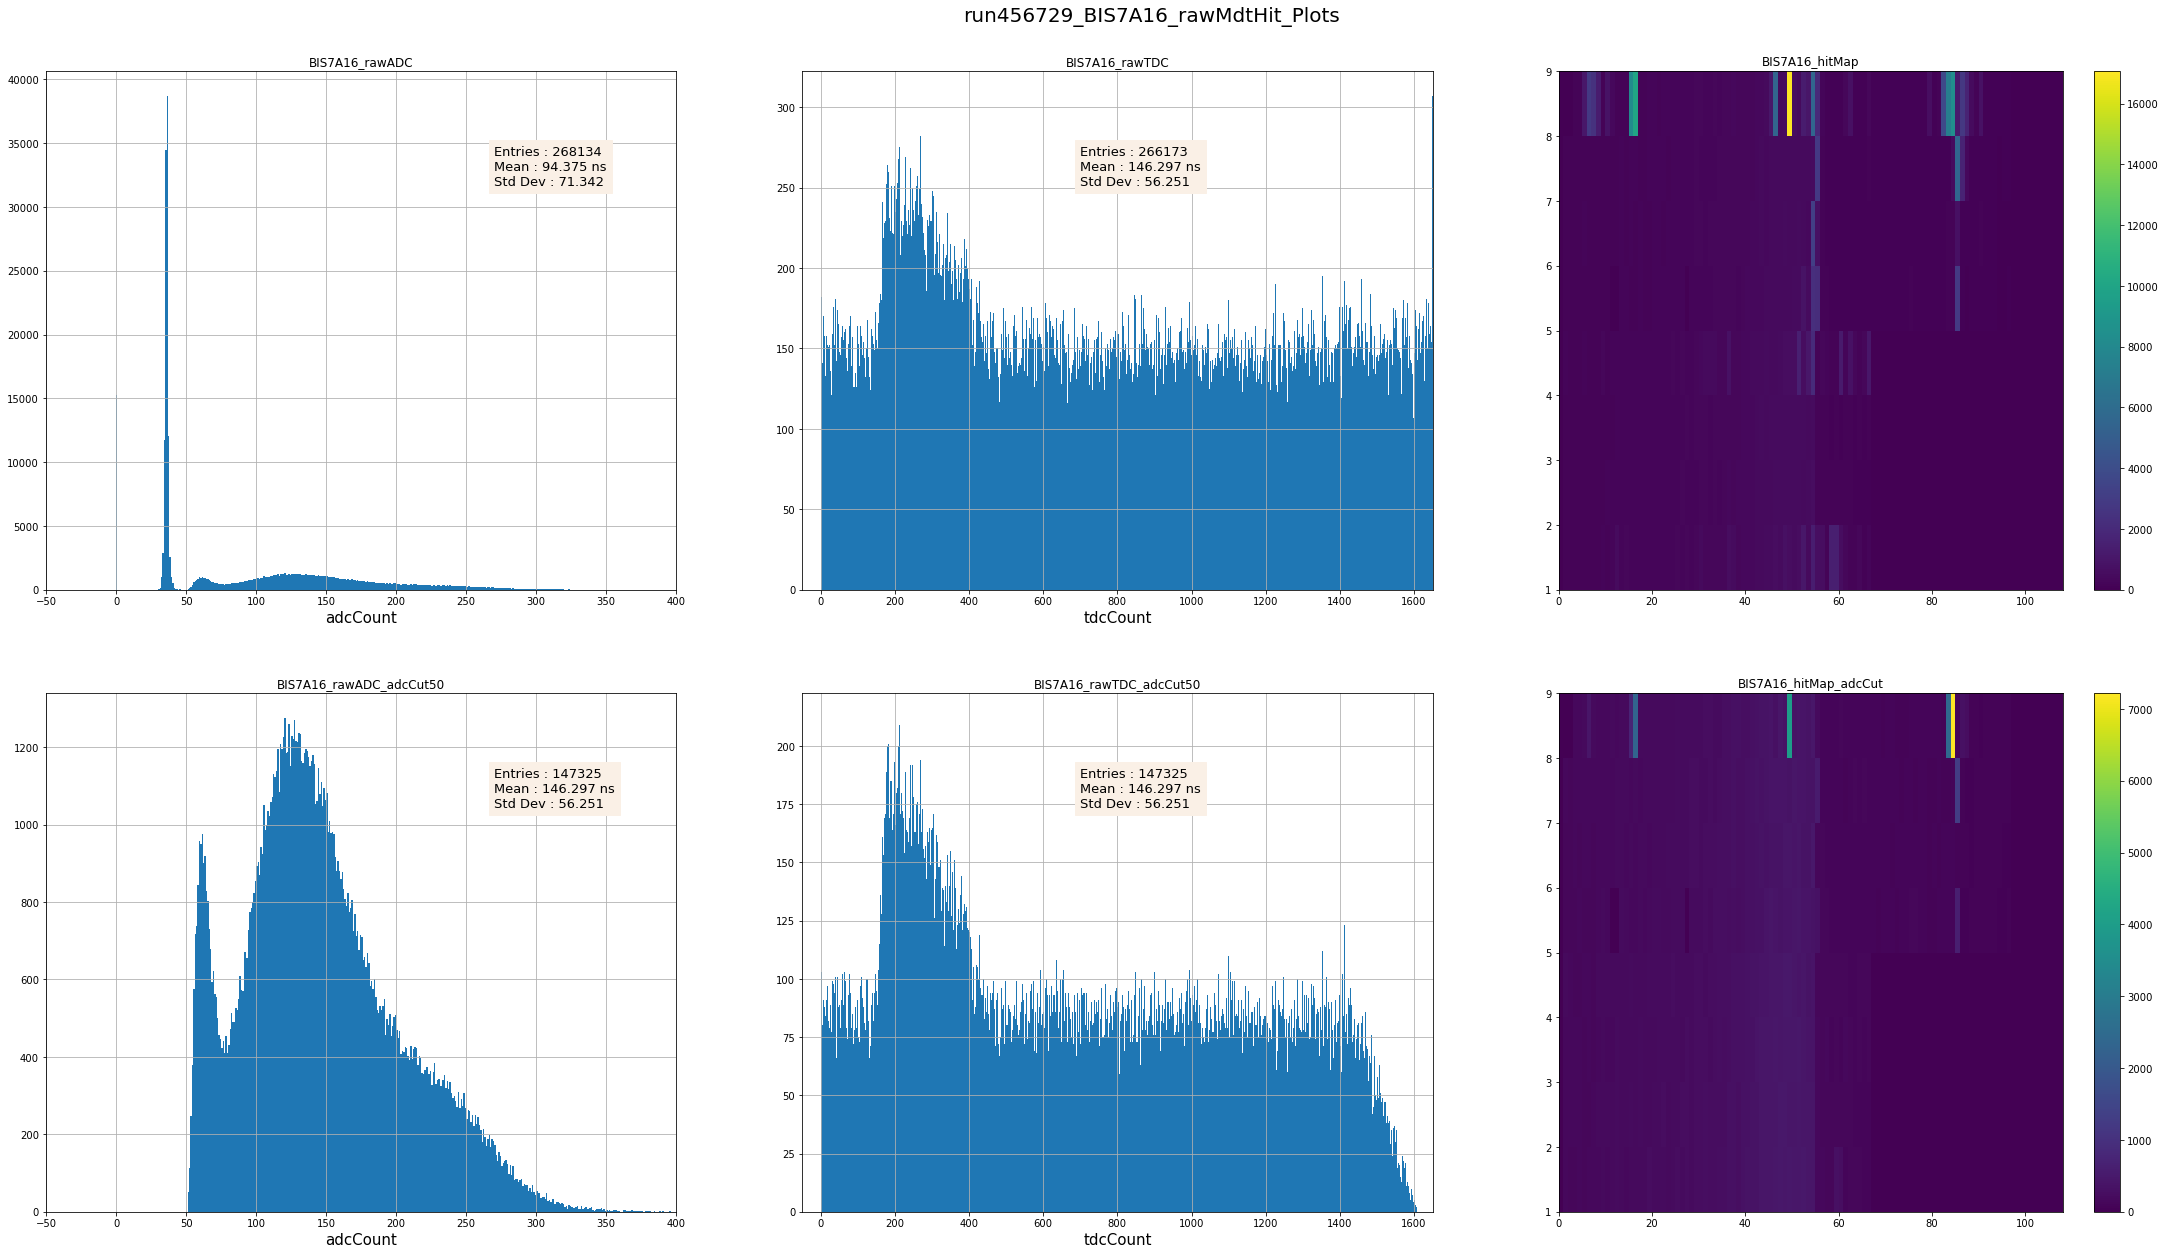

In [31]:
# predefined functions
# raw ADC and TDC hits plot with and without ADC cut at 50
def plotRawMdtHits(df_all,chamber):
    
    pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]
    adc_cut = 50
    pd_mdt_chamber_cut = pd_mdt_chamber[pd_mdt_chamber['rawMdt_adc']>adc_cut]
    
    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 18), nrows = 2, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
       
    # ADC count without cut
    mdt_adc = pd_mdt_chamber.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    mdt_adc_cut = pd_mdt_chamber_cut.rawMdt_adc.values.astype(float)
    xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    axes[1,0].set_xlim(min_adc,max_adc)
    axes[1,0].set_xlabel('adcCount',fontsize=15)
    axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,0].grid()
    axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')

    
    # raw TDC spectrum
    mdt_tdc = pd_mdt_chamber.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')

    
    mdt_tdc_cut = pd_mdt_chamber_cut.rawMdt_tdc.values.astype(float)
    xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1,1].set_xlim(min_tdc,max_tdc)
    axes[1,1].set_xlabel('tdcCount',fontsize=15)
    axes[1,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,1].grid()
    axes[1,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')
    
    # fit t0
    # driftTime spectrum
    #t0_fit,tmax_fit, axes[0,2] = mdtCalib_functions.fitT0Tmax(mdt_tdc_cut,chamber,axes[0,2])
    
    
    chamberinfo = list(pd_mdt_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]
    axes[0,2].set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = axes[0,2].hist2d(tb,nLayer, bins = [108,8], range= [[0,108],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    chamberinfo_cut = list(pd_mdt_chamber_cut.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    tb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[1,2].set_title(f'{chamber}_hitMap_adcCut')
    
    counts, xedges, yedges, im = axes[1,2].hist2d(tb,nLayer, bins = [108,8], range= [[0,108],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[1,2])
    
    fig.patch.set_facecolor('white')
    fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits(df_raw,'BIS7A16')

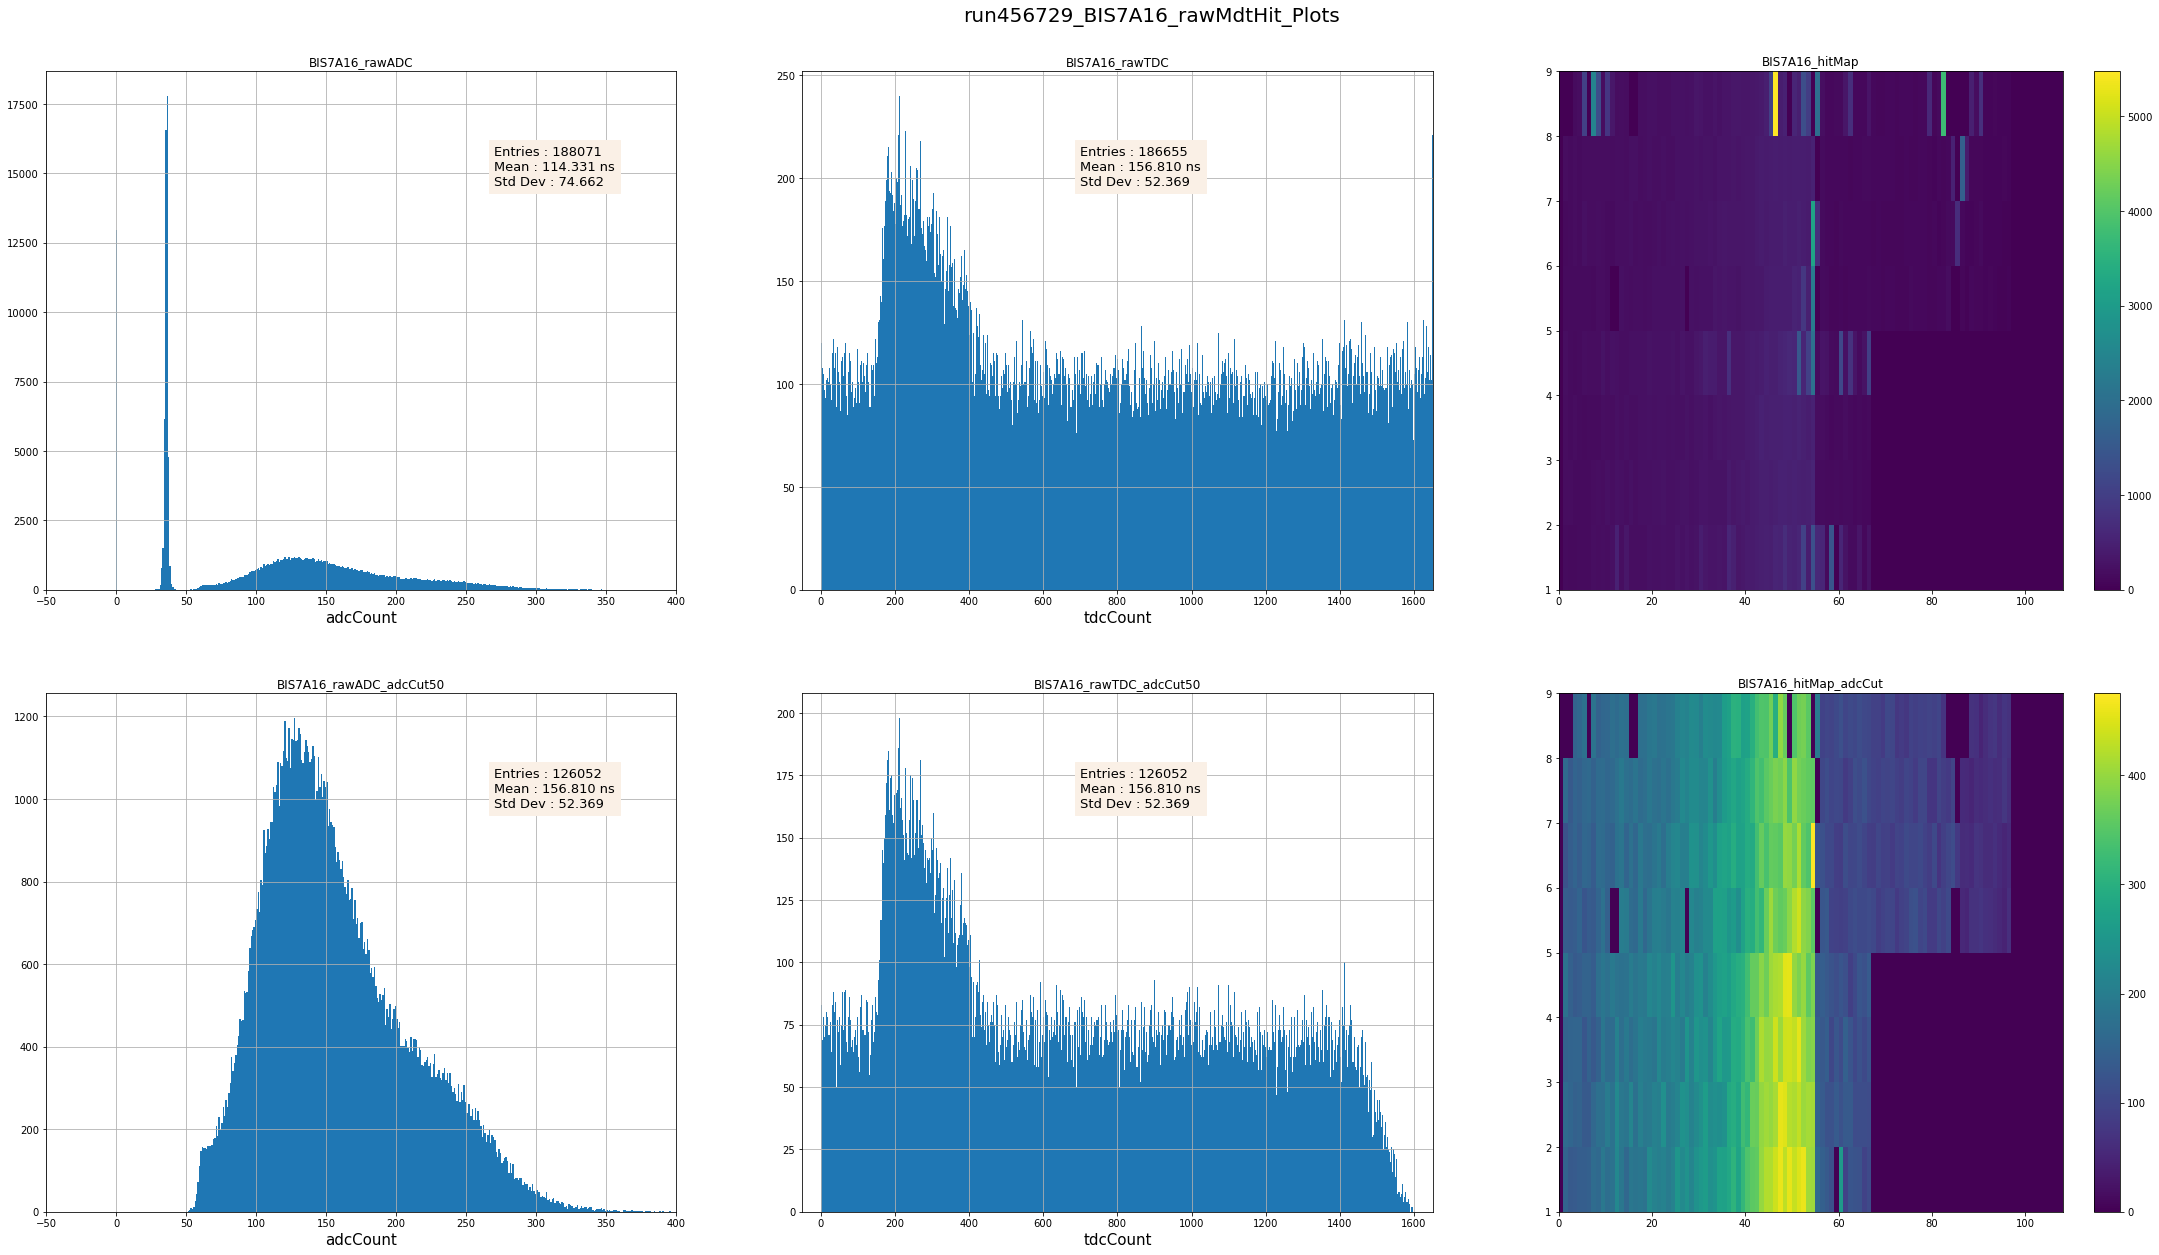

In [125]:
# plot the  hit by filter the track contains noisy tubes
df_raw_removeNoisyTubes = df_raw_BIS7A16[~df_raw_BIS7A16['rawMdt_tubeInfo'].isin(noisyList)]
plotRawMdtHits(df_raw_removeNoisyTubes,chamberName)

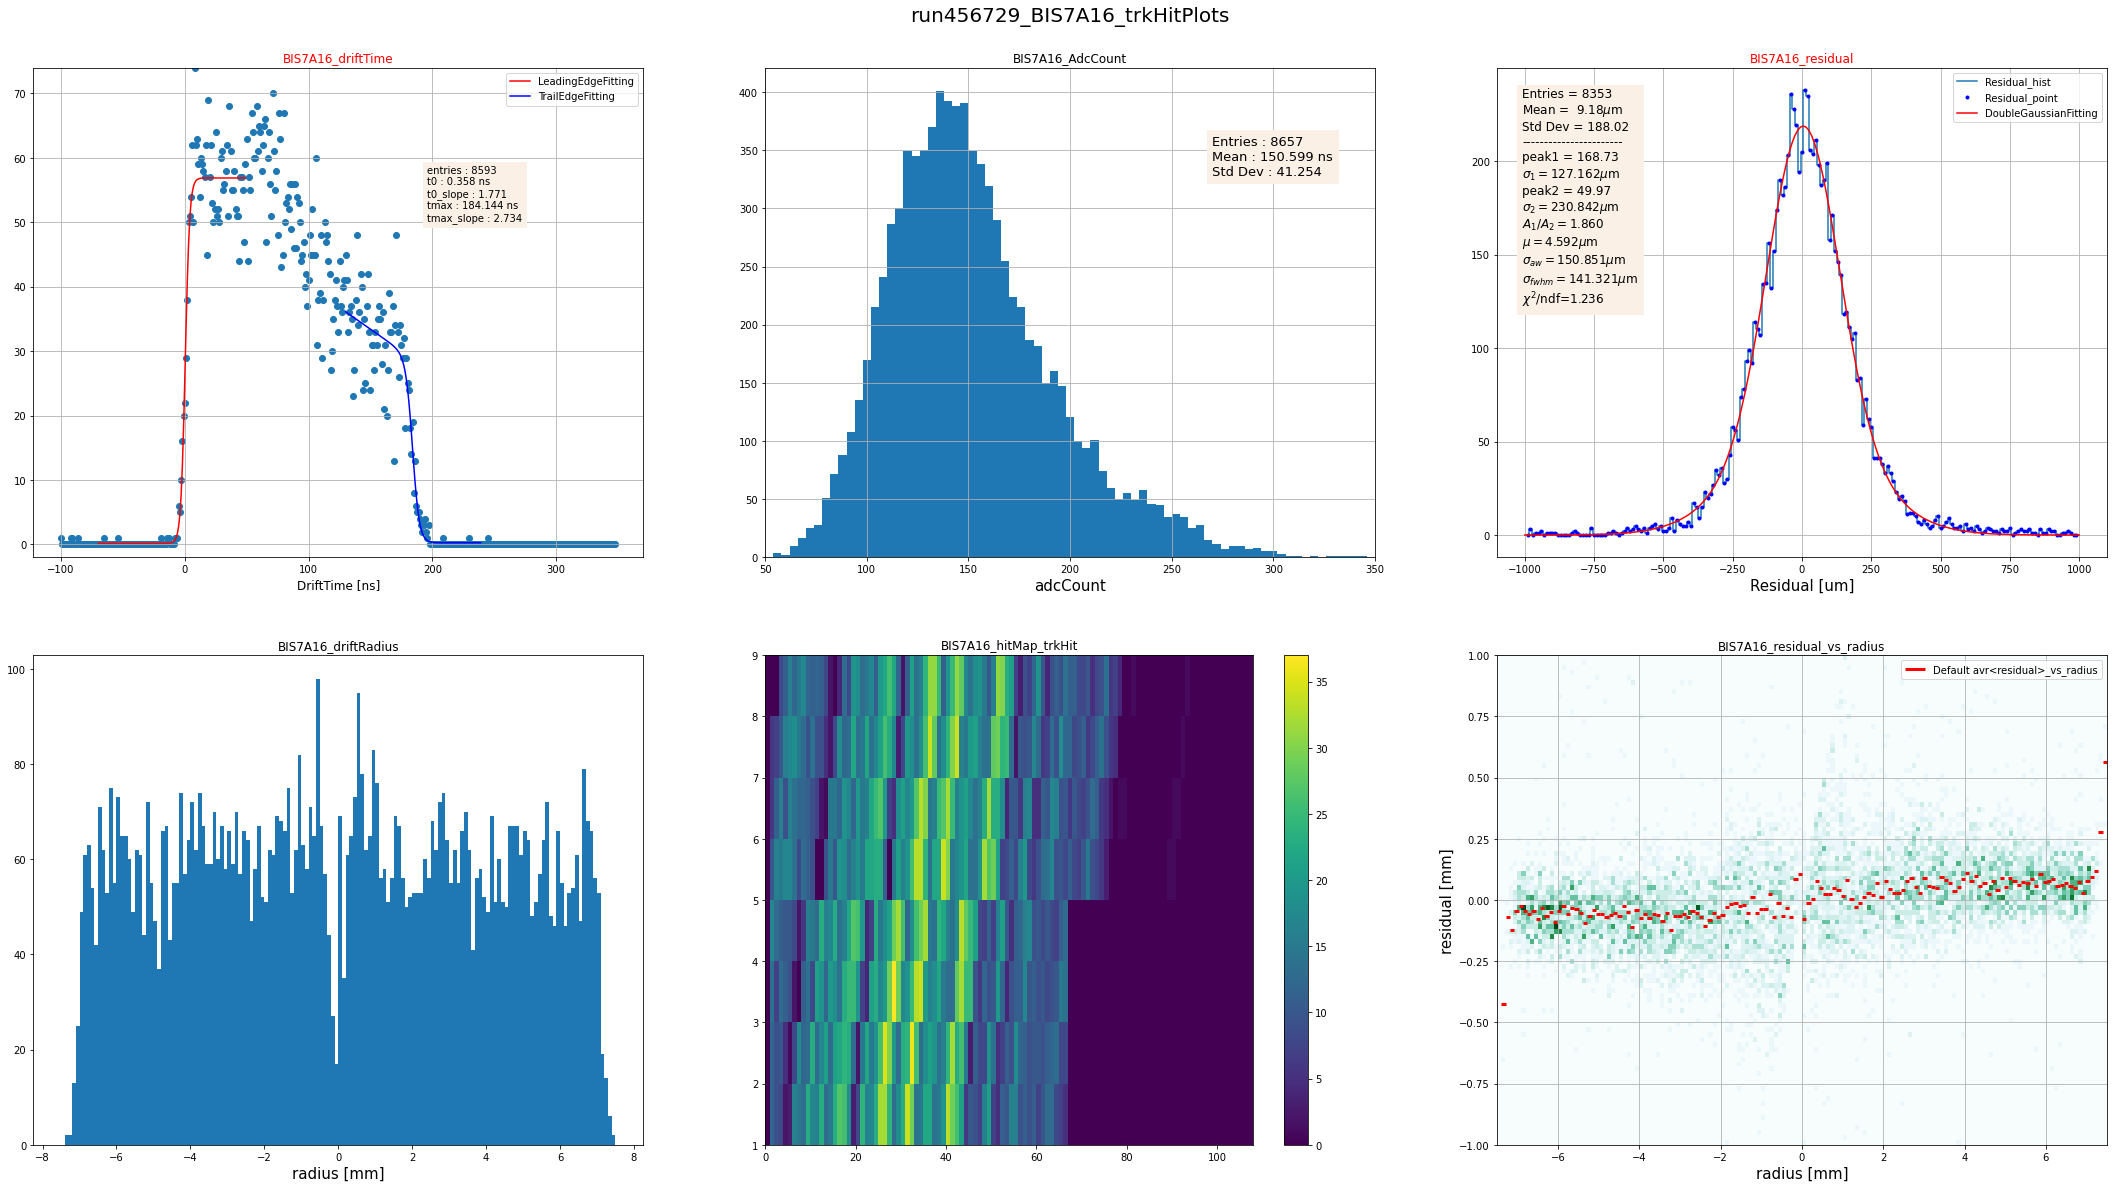

In [119]:
# track hits overall
# make chamber overall info
run = '456729'

def plotTrkMdtHits(df_trk,chamber):

    fig,axes = plt.subplots(figsize=(30, 17), nrows = 2, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.98, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_trkHitPlots'%(run,chamber), fontsize=20)
    
    pd_mdt_chamber = df_trk[df_trk['trkHit_station']==chamber]
    maxRadius, maxDriftTime = 15.0, 800.0
    #splitBin = 13  # sMDT = 25  MDT = 13
    if (chamber[:3] in ['BME','BMG']) or chamber[:5] == 'BIS7A':
        maxRadius, maxDriftTime = 7.5, 200.0

    # driftTime spectrum
    t0_fit,tmax_fit, axes[0,0] = mdtCalib_functions.fitT0Tmax(pd_mdt_chamber['trkHit_driftTime'],chamber,axes[0,0])
    axes[0,0].set_title(f'{chamber}_driftTime')
    
    # hitmap
    chamberinfo = list(pd_mdt_chamber.trkHit_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]
    axes[1,1].set_title(f'{chamber}_hitMap_trkHit')
    
    counts, xedges, yedges, im = axes[1,1].hist2d(tb,nLayer, bins = [108,8], range= [[0,108],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[1,1])
    

    # residual 
    mdt_resi = pd_mdt_chamber.trkHit_resi.values.astype(float)
    x1,bins1 = np.histogram(mdt_resi*1000,bins = np.arange(-1000,1000,10))
    mdtCalib_functions.fitResidual(x1,bins1,'Residual',axes[0,2])
    axes[0,2].set_title(f'{chamber}_residual')
    

    # radius distribution
    mdt_r = pd_mdt_chamber['trkHit_driftRadius'].values.astype(float)
    axes[1,0].hist(mdt_r,bins=150,range=[-7.5,7.5],label = 'r')
    axes[1,0].set_xlabel('radius [mm]',fontsize =15)
    axes[1,0].set_title(f'{chamber}_driftRadius')
    

    # ADC count
    mdt_adc = pd_mdt_chamber.trkHit_adc.values.astype(float)
    xadc, xbins, patch = axes[0,1].hist(mdt_adc,bins=75,range=[50,350],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,1].set_xlim(50,350)
    axes[0,1].set_xlabel('adcCount',fontsize=15)
    axes[0,1].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_AdcCount')
    

    # Residual vs Radius
    import matplotlib.colors as mpl
    counts, xedges, yedges, im2 = axes[1,2].hist2d(mdt_r, mdt_resi, bins=[150,100],range = [[-1*maxRadius,1*maxRadius],[-1,1]],cmap=plt.cm.BuGn,label='residual_vs_radius')
    #cmap.set_bad('white',1.)
    axes[1,2].set_ylim(-1,1)
    axes[1,2].set_xlim(-7.5,7.5)
    axes[1,2].set_xlabel('radius [mm]',fontsize=15)
    axes[1,2].set_ylabel('residual [mm]',fontsize=15)
    #plt.colorbar(im2, ax=axes[1,1])
    bin_means, bin_edges, binnumber = stats.binned_statistic(mdt_r, mdt_resi, statistic='median', bins=150)

    axes[1,2].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3,label='Default avr<residual>_vs_radius')
    axes[1,2].legend()
    axes[1,2].grid()
    axes[1,2].set_title(f'{chamber}_residual_vs_radius')

    fig.patch.set_facecolor('white')
    plt.savefig('run%s_%s_trkHitPlots.png'%(run,chamber))
    plt.show()

chamberName = 'BIS7A16'
plotTrkMdtHits(df_trk,chamberName)


In [43]:
pd_mdt_chamber = df_trk[df_trk['trkHit_station']==chamberName]
pd_mdt_chamber.head()

trkHit_FixedId  trkHit_adc  trkHit_tdc  trkHit_driftTime  \
entry subentry                                                             
83    0               24706065         181         265         84.618095   
      1               24706066         117         309        116.342682   
      2               24706194         112         184         20.165684   
      3               24706323         110         394        179.768219   
      4               24706324         120         216         45.550209   

                trkHit_resi trkHit_tubeInfo trkHit_station trkHit_type  
entry subentry                                                          
83    0            0.119585  BIS7A16-1-1-18        BIS7A16         BIS  
      1           -0.014553  BIS7A16-1-1-19        BIS7A16         BIS  
      2           -0.002272  BIS7A16-1-2-19        BIS7A16         BIS  
      3           -0.044591  BIS7A16-1-3-20        BIS7A16         BIS  
      4           -0.146015  BIS7A16-1-3-21        BIS7A16         BIS

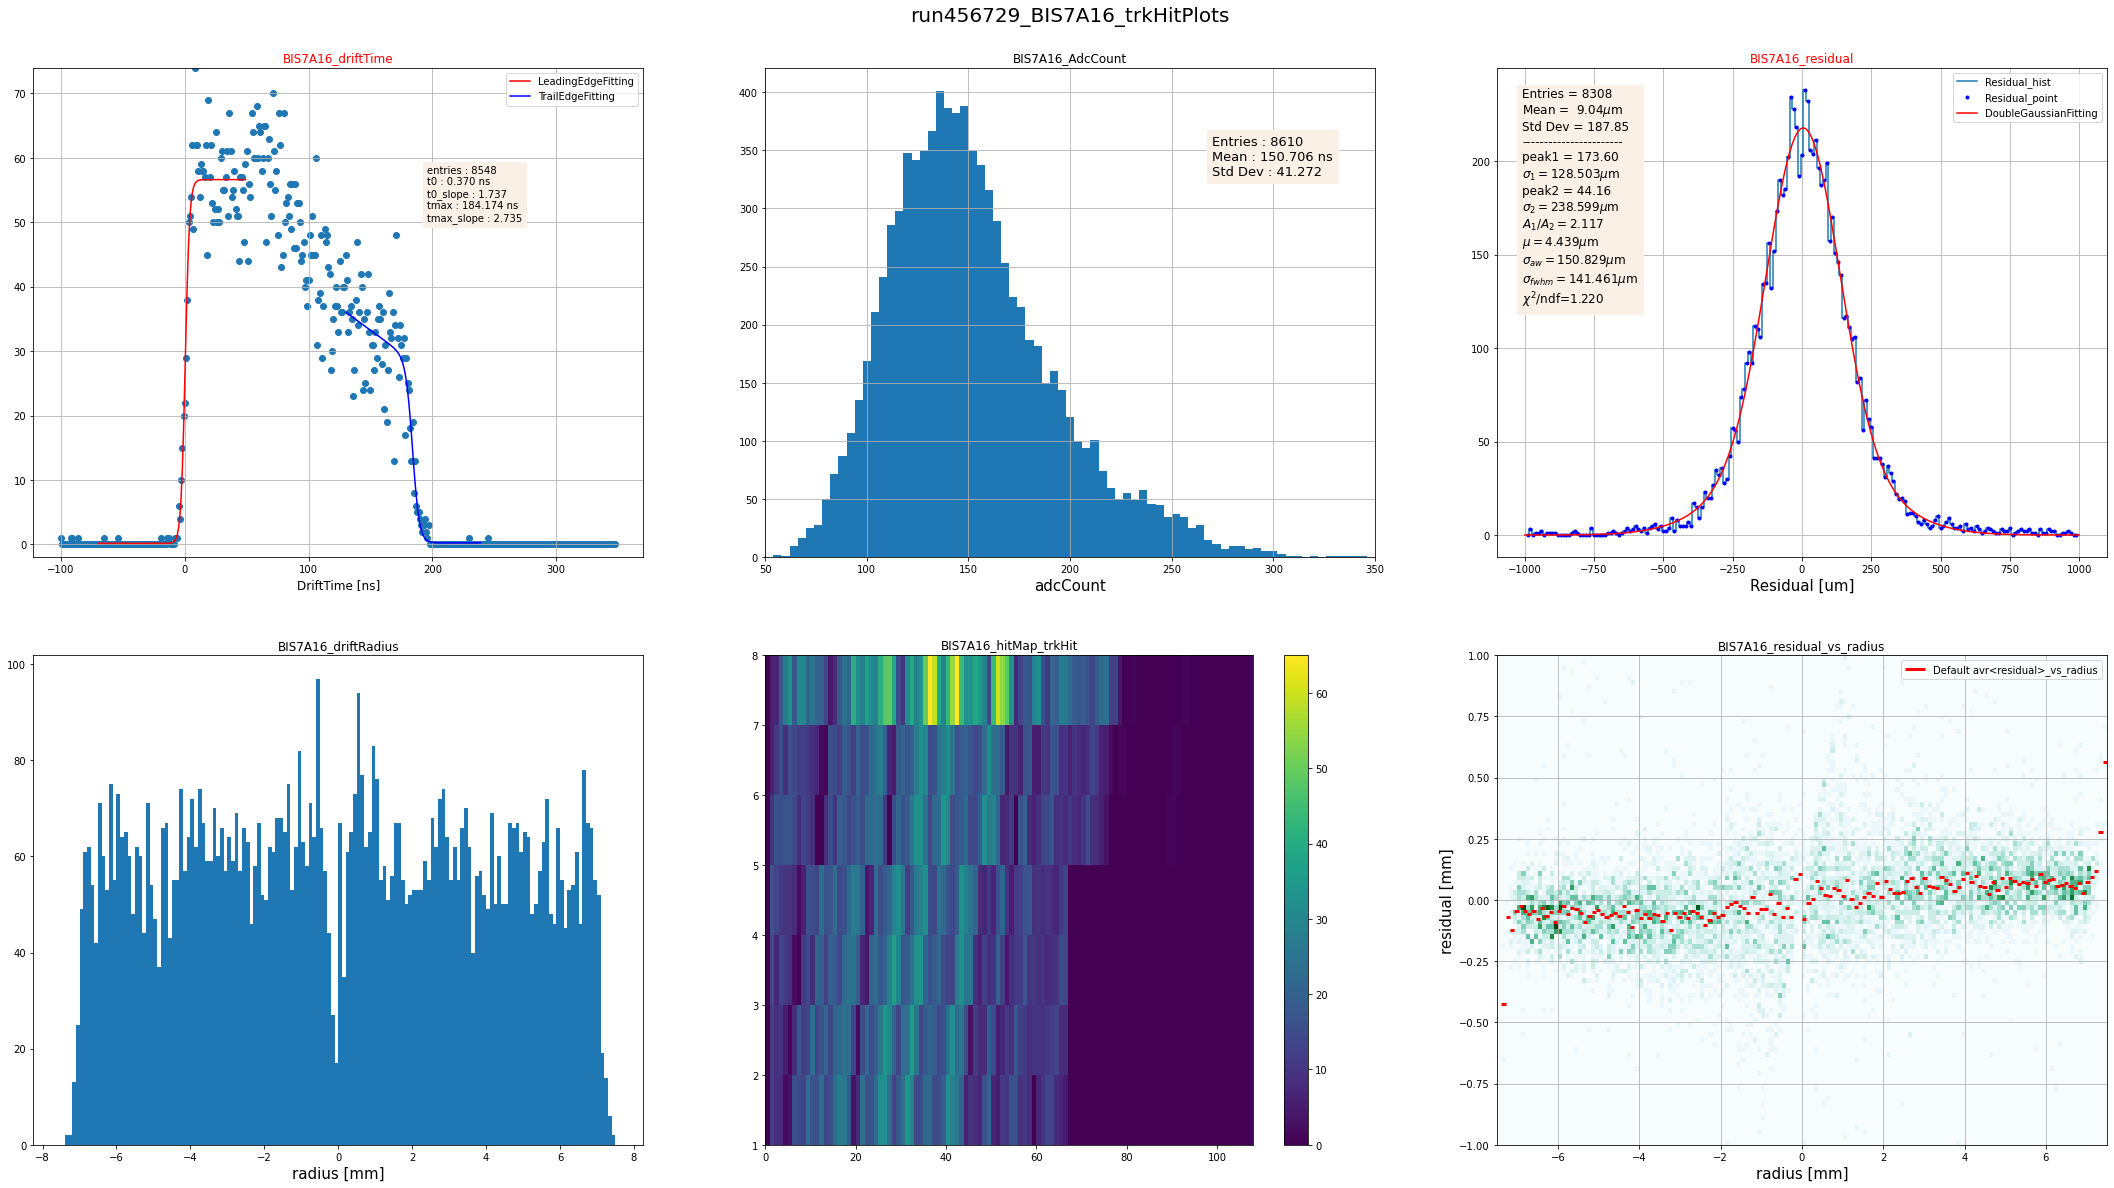

In [59]:
# plot the track hit by filter the track contains noisy tubes
df_trk_removeNoisyTubes = df_trk[~df_trk['trkHit_tubeInfo'].isin(noisyList)]
plotTrkMdtHits(df_trk_removeNoisyTubes,chamberName)

In [ ]:
# Create BIS7A16 segment cvs
# Multiple 

In [ ]:
# Refine T0/TMax and RT function


In [ ]:
# Refit segment with new calibration


In [ ]:
# Compare the resolution